# Project 2: Uncles and Uncles Rewards
- Model a Blockchain that uses uncles and uncle rewards
- Model rewarding mechanism to reward uncle block creators
- Model selfish mining (only one attacker) in this blockchain

Try to answer the following questions with your experiment:
1. How do uncles improve the fairness of the blockchain? For this, you should compare the outcome of miners with and without uncles.
2. What is the impact of uncles on selfish mining? Is selfish mining more profitable with uncles?
3. What does it mean in this model for the selfish mining attack to be profitable?

 Since more miners will get rewards for mining, even if they don't finish a block that is part of the longest chain, they will be rewarded for it. So the time and energy used for that block will not be as wasted, and it seems more rewarding to mine. Show net money with and without uncle rewards to display point. The concept of it is for fairness, but may encourage selfish mining. 

### Imports

In [13]:
#Import statements
from draw_blockchain import show
import hashlib as hasher
import random
import numpy as np

### Hash function

In [14]:
def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def hash(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    #print(type(inputbytes))
    hash_obj.update(inputbytes)
    return hash_obj.hexdigest()

def numberOfInitZeros(hashStr):
    count = 0
    for i in range (0 , len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

### Block

In [15]:
class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0 , "0")
            self.height = 0
            self.color = "#AEF751"
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
            self.color = creator.color
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))

    def print(self):
        print(self.data + " "+ self.creator.name + " " + str(self.height))

### Blockchain

In [16]:
class Blockchain:
    def __init__(self, genesis_data, difficulty, blockReward=10):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0
        self.block_reward = blockReward
        self.uncles = []

    def longestChain(self):
      max = self.chain[0].height
      for block in self.chain:
          if block.height > max:
                max = block.height
      maxes = [block for block in self.chain if block.height == max]
      r = random.choices(maxes, k=1)
      return r[0]
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1
        if self.inlongestChain(newBlock):
            newBlock.creator.reward += self.block_reward
        else:  
            self.uncles.append(newBlock)
        
    def print(self):
        for block in self.chain:
            block.print()
            print("________")

    def hasFork(self):
        for block1 in self.chain:
            for block2 in self.chain:
                if block1!=block2 and block1.height == block2.height:
                    return True
        return False

    def checkMiner(self, miner):
      last = self.longestChain()
      count = 0
      while last!=None:
          if last.creator == miner:
                count += 1
          last = last.previous
      return count
    
    def inlongestChain(self, block):
          last = self.longestChain()
          while last!= None:
                if last == block: #need more of a check for if fork
                        # print("last",last.height,"block", block.height)
                        return True
                last = last.previous
          return False
          
    #Think this one works but not 110% sure yet
    def forks(self):
        fork_list = []
        last = self.longestChain()
        while last != None:
            # print(last.creator.name)
            for child in last.children:
                if not self.inlongestChain(child):
                    length = 1
                    forkblock = child
                    while forkblock.children:
                        length += 1
                        forkblock = forkblock.children[0]
                    fork_list.append(length)
            last = last.previous
        return fork_list


### Uncle blockchain

In [17]:
class UncleBlockchain(Blockchain):
    def __init__(self, genesis_data, difficulty, block_reward=10, uncle_reward=5):
        super().__init__(genesis_data, difficulty, blockReward=block_reward)
        self.uncle_reward = uncle_reward
        self.uncles = []
    
    def add(self, new_block):
        self.chain.append(new_block)
        new_block.previous.children.append(new_block)
        self.size +=1
        if self.inlongestChain(new_block):
            new_block.creator.reward += self.block_reward
            if self.uncles and new_block.height > self.uncles[0].height:
                self.referenceUncle()
        else:  
            self.uncles.append(new_block)

    def referenceUncle(self):
        uncleblock = self.uncles[-1]
        uncleblock.creator.reward += self.uncle_reward
        self.uncles.pop()

## Miners

### Normal miner

In [18]:
class Miner:
    def __init__(self, miningPower, name, blockchain=None):
        self.miningPower = miningPower
        self.nonce = random.randint(0,100000) #original one
        # self.nonce = 0
        self.name = name
        self.blockchain = blockchain
        self.reward = 0
        self.color = "#7EDBF6"
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()
    
    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        if latest.height > self.lastBlock.height:
              self.lastBlock = latest

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= self.blockchain.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1


### Selfish miner

In [19]:

class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False
        self.color = "#F59AEE"

    def UpdateLast(self):
        #add this function
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        #add this function
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= self.blockchain.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

## Main program

### Run function

In [20]:
#Main
def run(
        reward=10, uncle_reward=0,
        difficulty=10,
        num_miners=10,
        num_selfish_miners=0,
        mining_power=10,
        mining_power_selfish=15,
        genesis_data="0",
        num_blocks = 30,
        miners = []
    ):
    bc = None
    if uncle_reward > 0:
        bc = UncleBlockchain(genesis_data , difficulty, reward, uncle_reward)
    else:
        bc = Blockchain(genesis_data , difficulty, reward)
    miners = [Miner(p, "m"+ str(i), bc) for i,p in enumerate(miners)]
    selfish = []
    len_miners = len(miners)
    for i in range(num_miners):
        miners.append(Miner(mining_power ,"m"+str(len_miners+i), bc))
    for i in range(num_selfish_miners):
        selfish.append(SelfishMiner(mining_power_selfish ,"s"+str(i), bc))
    while bc.size < num_blocks:
        for s in selfish:
            s.PoWSolver()

        for m in miners:
            m.PoWSolver()

        for s in selfish:
            s.UpdateLast()

        for m in miners:
            m.UpdateLast()
    return bc, miners, selfish

def print_run(bc, miners, selfish):
    print("Has fork:", bc.hasFork())
    longest_chain = bc.longestChain()
    print("Longest chain height:",longest_chain.height)
    selfish_power = 0
    for s in selfish:
        selfish_power+=s.miningPower
        print(s.name, bc.checkMiner(s))
        print("Fraction {}".format(bc.checkMiner(s) /longest_chain.height ))
    total = selfish_power
    for m in miners:
        total += m.miningPower
    print("alpha {}".format(selfish_power / total))
    for m in miners:    
        print(m.name ,m.reward)
    for s in selfish:    
        print(s.name ,s.reward)
        

In [21]:
import matplotlib.pyplot as plt
from matplotlib import colors
# show(bc)
# miner_rewards_avg = [0]*20
# miner_names_avg = []
# for i in range(10):
#     bc, m, s = run(num_miners=20, num_blocks=1000)
    # for mi in range(0,len(m)):
        # print(miner_rewards_avg,"avg")
        # print(m[mi])
        # miner_rewards_avg[mi] += m[mi].reward
# miner_rewards_avg[:] = [x / 10 for x in miner_rewards_avg]
    
# bc, m, s = run(num_miners=20, num_blocks=1000)

# miner_rewards = []
# for miners in m:
#     miner_rewards.append((miners.reward))
# miner_names = ["m"+ str(i) for i, _ in enumerate(miner_rewards_avg)]
# plt.bar(miner_names,miner_rewards_avg)
#Need this for testing later :))

In [22]:
def getRewards(miners):
    miner_rewards = []
    for m in miners:
        miner_rewards.append(m.reward)
    miner_names = ["m"+ str(i) for i, _ in enumerate(miner_rewards)]
    return miner_names, miner_rewards
    
def getavg(num):
    miner_rewards_avg = [0]*20
    for i in range(num):
        bc, m, s = run(num_miners=20, num_blocks=1000)
        _, rewards = getRewards(m)
    for mi in range(len(m)):
        miner_rewards_avg[mi] += m[mi].reward 
    miner_rewards_avg[:] = [x / num for x in miner_rewards_avg]
    miner_names = ["m"+ str(i) for i, _ in enumerate(miner_rewards_avg)]
    return miner_rewards_avg, miner_names

### Baseline

To begin with we ran the blockchain with 20 different miners and 1000 blocks mined in total. This was done 10 times and we normalised the rewards for each miner and plotted it. This showed us that all the miners had _about_ the same amount of reward when mining for a long time, on many blocks. We can now conclude that the blockchain is somewhat fair, because same amount of mining power roughly equals same reward.

We also did this with a single miner that had 3X the mining power of the other nodes to see if there were any difference. The miner with 3X mining power got about 3x the reward of a "_average_" miner. This also works as intended.

In [23]:
# Multiple runs to show normal, uncles, normal big and uncle big
miner_rewards_normal = [0]*15
for i in range(10):
    bc, m, s = run(num_miners=15, num_blocks=1000)
    # bc, m, s = run(num_miners=20, num_blocks=1000, miners=[30])
    _, rewards = getRewards(m)
    for mi in range(len(m)):
        # print(mi, len(miner_rewards_avg),len(m))
        miner_rewards_normal[mi] += m[mi].reward 
miner_rewards_normal[:] = [x / 10 for x in miner_rewards_normal]
miner_names = ["m"+ str(i) for i, _ in enumerate(miner_rewards_normal)]
# plt.bar(miner_names,miner_rewards_normal)

miner_rewards_uncles = [0]*15
for i in range(10):
    bc, m, s = run(num_miners=15, num_blocks=1000,uncle_reward=10)
    # bc, m, s = run(num_miners=20, num_blocks=1000, miners=[30])
    _, rewards = getRewards(m)
    for mi in range(len(m)):
        # print(mi, len(miner_rewards_avg),len(m))
        miner_rewards_uncles[mi] += m[mi].reward 
miner_rewards_uncles[:] = [x / 10 for x in miner_rewards_uncles]

miner_rewards_normal_big = [0]*15
for i in range(10):
    bc, m, s = run(num_miners=14, num_blocks=1000,miners=[20])
    # bc, m, s = run(num_miners=20, num_blocks=1000, miners=[30])
    _, rewards = getRewards(m)
    for mi in range(len(m)):
        # print(mi, len(miner_rewards_avg),len(m))
        miner_rewards_normal_big[mi] += m[mi].reward 
miner_rewards_normal_big[:] = [x / 10 for x in miner_rewards_normal_big]

miner_rewards_uncles_big = [0]*15
for i in range(10):
    bc, m, s = run(num_miners=14, num_blocks=1000,miners=[20], uncle_reward=10)
    # bc, m, s = run(num_miners=20, num_blocks=1000, miners=[30])
    _, rewards = getRewards(m)
    for mi in range(len(m)):
        # print(mi, len(miner_rewards_avg),len(m))
        miner_rewards_uncles_big[mi] += m[mi].reward 
miner_rewards_uncles_big[:] = [x / 10 for x in miner_rewards_uncles_big]


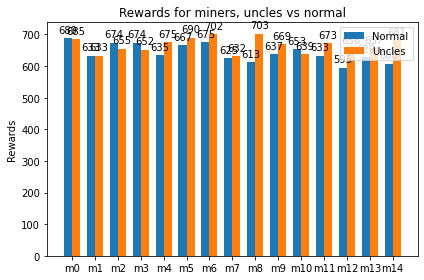

In [24]:
# liste = bc.forks()
# print(liste)
# print("number of forks: ", len(liste))
# # show(bc)
# miner_rewards = []n xpos   miner_rewards.append((miners.reward))
# miner_names = ["m"+ str(i) for i, _ in enumerate(miner_rewards)]
# plt.bar(miner_names,miner_rewards)
# plot for showing forks and "normal" run
# plt.subplot(1,3,1)
# plt.bar(miner_names,miner_rewards_normal)
width = 0.35
xpos = np.arange(len(miner_names))

fig, ax = plt.subplots()
normal = ax.bar(xpos - width/2,miner_rewards_normal,width, label="Normal")
uncles = ax.bar(xpos + width/2,miner_rewards_uncles,width, label="Uncles")

ax.set_ylabel("Rewards")
ax.set_title("Rewards for miners, uncles vs normal")
ax.set_xticks(xpos)
ax.set_xticklabels(miner_names)
ax.legend()
ax.bar_label(normal,padding=3)
ax.bar_label(uncles,padding=3)
fig.tight_layout()
plt.show()
# ax[0,0].plot(miner_names,miner_rewards_normal)
# ax[0,0] = 

# print(np.std(miner_rewards_normal))
# print(np.average(miner_rewards_normal))
# print(miner_rewards_normal)

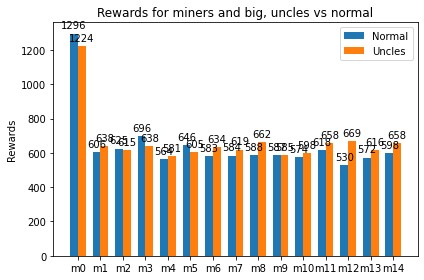

In [26]:
width = 0.35
xpos = np.arange(len(miner_names))

fig, ax = plt.subplots()
normal = ax.bar(xpos - width/2, miner_rewards_normal_big, width, label="Normal")
uncles = ax.bar(xpos + width/2, miner_rewards_uncles_big, width, label="Uncles")

ax.set_ylabel("Rewards")
ax.set_title("Rewards for miners and big, uncles vs normal")
ax.set_xticks(xpos)
ax.set_xticklabels(miner_names)
ax.legend()
ax.bar_label(normal,padding=3)
ax.bar_label(uncles,padding=3)
fig.tight_layout()
plt.show()

In [34]:
print(np.std(miner_rewards_normal))
print(np.average(miner_rewards_normal))
print(sum(miner_rewards_normal))

print(np.std(miner_rewards_uncles))
print(np.average(miner_rewards_uncles))
print(sum(miner_rewards_uncles))
## Standard deviation for uncles is less than normal bc, aka more "fair"

27.06206857495479
642.6666666666666
9640.0
22.253688832790544
666.8
10002.0


### Testing unclerewards

To test uncle rewards we could employ many different ways of testing fairness, but we chose to do a...? Dunno what to write
-> show with code and plot what we mean. Numbers plot, whatever. Below we have run the application X times and the plot proves ... Code for uncles does not seem to work :((




## Selfish mining

When a blockchain has implemented a uncle reward mechanism it eliminates some risk for the miners. When they mine a block that ends up outside the longest chain it will still be compensated somewhat for the time and energy put into the block, even if it is not on the level of the blockreward. However the blockchain may be more vulnerable to selfish mining attacks. Below you can see a model of a big miner on a uncle blockchain and a selfish miner on a uncle blockchain, where both of these have the same amount of _power_. So the difference is only how each of these miners behave. One of them will try to hide their blocks and one just publishes them. So if a uncle blockchain is more profitable to a selfish miner he should end up with more rewards than the big miner. 

In [48]:
miner_rewards_uncles_selfish = [0]*15
for i in range(10):
    bc, m, s = run(num_miners=14, num_blocks=1000, mining_power_selfish=20, num_selfish_miners=1, uncle_reward=10)
    # bc, m, s = run(num_miners=20, num_blocks=1000, miners=[30])
    _, rewards = getRewards(m)
    ml = [s[0].reward]
    ml.extend(rewards)
    for mi in range(len(ml)):
        # print(mi, len(miner_rewards_avg),len(m))
        miner_rewards_uncles_selfish[mi] += ml[mi] 
miner_rewards_uncles_selfish[:] = [x / 10 for x in miner_rewards_uncles_selfish]


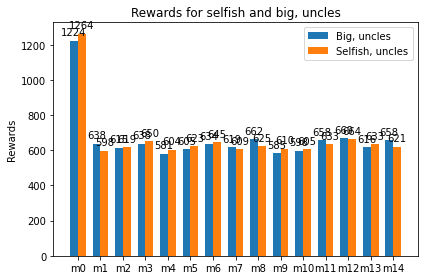

[1264.0, 598.0, 619.0, 650.0, 604.0, 623.0, 645.0, 609.0, 625.0, 610.0, 605.0, 633.0, 664.0, 633.0, 621.0]


In [50]:
width = 0.35
xpos = np.arange(len(miner_names))

fig, ax = plt.subplots()
normal = ax.bar(xpos - width/2, miner_rewards_uncles_big, width, label="Big, uncles")
uncles = ax.bar(xpos + width/2, miner_rewards_uncles_selfish, width, label="Selfish, uncles")

ax.set_ylabel("Rewards")
ax.set_title("Rewards for selfish and big, uncles")
ax.set_xticks(xpos)
ax.set_xticklabels(miner_names)
ax.legend()
ax.bar_label(normal,padding=3)
ax.bar_label(uncles,padding=3)
fig.tight_layout()
plt.show()
print(miner_rewards_uncles_selfish)